# Cactus Classification in the Biosphere Reserve

Dataset: subset of satellite images from the biosphere reserve in mexico


# Import Dependencies
### Load in the libraries that you will need

In [16]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread
import imageio as imread

from keras import backend as K
# from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
# from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
# from keras.models import Sequential,Input,Model
from tensorflow import keras
# from tensorflow.keras.models import Sequential, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
# from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

/tmp/ipykernel_79881/376618460.py:27: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom


In [17]:
!python --version

Python 3.11.6


In [18]:
import keras
print(keras.__version__)

3.3.2


# Custom Function
### function for visualizing training results

In [19]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

# Image Preprocessing
### Thank to Keras ImageDataGenerator for image preprocessing and data augmentation

In [20]:
augs_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)  

train_gen = augs_gen.flow_from_directory(
    'archive/training_set/training_set',
    target_size = (32,32),
    batch_size=32,
    shuffle=True,
    class_mode = 'binary'
)

test_gen = augs_gen.flow_from_directory(
    'archive/validation_set/validation_set/',
    target_size=(32,32),
    batch_size=32,
    shuffle=False,
    class_mode = 'binary'
)

Found 17500 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


# Model
### This is the LE-Net5 model from the research paper for this dataset

In [21]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(5,5), activation='sigmoid', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(16, kernel_size=(5,5), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(120, activation='tanh'))
model.add(Dense(84, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))


/home/akz-workhorse/programming/NASA-Hackathon/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,241 (239.22 KB)

 Trainable params: 61,241 (239.22 KB)

 Non-trainable params: 0 (0.00 B)

model = Sequential()
model.add(Conv2D(6, kernel_size=(5,5),activation='relu',input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2,strides=2))
model.add(Conv2D(16,kernel_size=5,strides=1,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2,strides=2))
model.add(Flatten())
model.add(Dense(120,activation='relu'))
model.add(Dense(84,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()


SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Callbacks
### Here we use Keras callbacks to monitor how the training is going and adjust the training accordingly

In [25]:
# #-------Callbacks-------------#

# best_model_weights = './base.model'

# checkpoint = ModelCheckpoint(
#     best_model_weights,
#     monitor='val_loss',
#     verbose=1,
#     save_best_only=True,
#     mode='min',
#     save_weights_only=False,
#     save_freq=1
# )

# #earlystop = EarlyStopping(
# #    monitor='val_loss',
# #    min_delta=0.001,
# #    patience=10,
# #    verbose=1,
# #    mode='auto'
# #)

# #tensorboard = TensorBoard(
# #    log_dir = './logs',
# #    histogram_freq=0,
# #    batch_size=16,
# #    write_graph=True,
# #    write_grads=True,
# #    write_images=False,
# #)

# #csvlogger = CSVLogger(
# #    filename= "training_csv.log",
# #    separator = ",",
# #    append = False
# #)

# #lrsched = LearningRateScheduler(step_decay,verbose=1)

# #reduce = ReduceLROnPlateau(
# #    monitor='val_loss',
# #    factor=0.5,
# #   patience=5,
# #    verbose=1, 
# #    mode='auto',
# #    cooldown=1 
# #)

# #callbacks = [checkpoint,tensorboard,csvlogger,reduce]

# callbacks = [checkpoint]



checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    save_freq='epoch'  # Save every epoch (or use an integer for saving every N batches)
)


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=./base.model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint


In [27]:
model = Sequential()

# Input layer (assuming your images are 32x32x3 RGB channels)
model.add(Conv2D(6, kernel_size=(5, 5), activation='sigmoid', input_shape=(32, 32, 3)))

# First convolutional block
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten layer before dense layers
model.add(Flatten())

# Dense layers for classification
model.add(Dense(120, activation='tanh'))
model.add(Dense(84, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model (replace with your optimizer, loss function, and metrics)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/home/akz-workhorse/programming/NASA-Hackathon/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
checkpoint = ModelCheckpoint(
    filepath='./best_model',  # Save the model to this directory
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False  # Save the entire model (architecture and weights)
)


TypeError: ModelCheckpoint.__init__() missing 1 required positional argument: 'filepath'

# Train The Model
### Here we train the model with our generators

In [32]:
# opt = SGD(learning_rate=2e-4, momentum=0.99)  # Use learning_rate instead of lr

# # opt = SGD(lr=2e-4, momentum=0.99)
# #opt1 = Adam(lr=1e-4)

# model.compile(
#     loss='binary_crossentropy',
#     optimizer=opt,
#     metrics=['accuracy']
# )

# history = model.fit_generator(
#     train_gen, 
#     validation_data = test_gen,
#     validation_steps = 100,
#     steps_per_epoch  = 100, 
#     epochs = 5,
#     verbose = 1
#     # callbacks=callbacks
# )

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2  # Split 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    'archive/training_set/training_set',
    target_size=(32, 32),
    batch_size=32,
    subset='training',  # Use training data only
    class_mode='binary'
)

validation_generator = train_datagen.flow_from_directory(
    'archive/training_set/training_set',  # Use training data for validation (due to validation_split)
    target_size=(32, 32),
    batch_size=32,
    subset='validation',  # Use validation data only
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'archive/validation_set/validation_set/',  # Assuming validation data directory
    target_size=(32, 32),
    batch_size=32,
    shuffle=False,
    class_mode='binary'
)

# Build the LeNet-5 model
model = Sequential()

# Input layer (assuming your images are 32x32x3 RGB channels)
model.add(Conv2D(6, kernel_size=(5, 5), activation='sigmoid', input_shape=(32, 32, 3)))

# First convolutional block
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten layer before dense layers
model.add(Flatten())

# Dense layers for classification
model.add(Dense(120, activation='tanh'))
model.add(Dense(84, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
opt = SGD(learning_rate=2e-4, momentum=0.99)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model using model.fit_generator
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),  # Steps per epoch for training data
    validation_steps=len(validation_generator),  # Steps per epoch for validation data
    epochs=10,  # Adjust the number of epochs as needed
    verbose=1  # Set to 0 for silent training
)

# Evaluate the model on the test data (optional)
test_loss, test_acc = model.evaluate_generator(test_generator)
print('Test accuracy:', test_acc)


Found 14001 images belonging to 2 classes.
Found 3499 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


AttributeError: 'Sequential' object has no attribute 'fit_generator'

# Evaluation
### Here we visualize the training, load the the best weights from the model, evaluate the model, and save the weights

Model Test Loss: 0.6304925900697708
Model Test Accuracy: 0.6875
Weights Saved


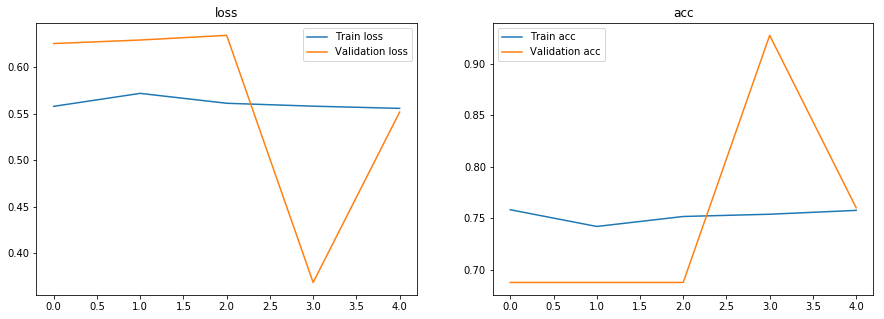

In [24]:
show_final_history(history)
plt.savefig('performace.eps', format='eps')

model.load_weights(best_model_weights)
model_eval = model.evaluate_generator(test_gen,steps=100)
print("Model Test Loss:",model_eval[0])
print("Model Test Accuracy:",model_eval[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")